In [11]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import vc_utils as vutils
import joblib


In [2]:
dataset = pd.read_pickle('../../geodata/results/01_master_building_dataset.pkl').reset_index()

In [3]:
maxvsh_cols    = dataset.columns[dataset.columns.str.contains('maxvsh')].tolist()
vaccess_cols   = dataset.columns[dataset.columns.str.contains('vwa')].tolist()
# mean_cols      = dataset.columns[dataset.columns.str.contains('mn')].tolist()
dist_cols      = dataset.columns[dataset.columns.str.contains('sum_')].tolist()
vconfig_cols   = np.setdiff1d(dataset.columns[np.where(dataset.columns == 'snt_0')[0][0]:np.where(dataset.columns == 'cmpx_gini')[0][0]+1].tolist(),dist_cols).tolist()
id_cols        = ['ID_Geb','Stockwerk','FassPktX','FassPktY','FassPktZ']

dataset['unit_pano'] = dataset['unit_pano'].fillna(0)

In [4]:
# selected columns used in script
sel_cols    = maxvsh_cols+vaccess_cols+vconfig_cols + dist_cols+id_cols
income_cols = dataset.columns[np.where(dataset.columns == 'net_income')[0][0]:np.where(dataset.columns == 'deductPCT')[0][0]+1].tolist()

In [5]:
urban_form_names = dataset.groupby("NAME").size().sort_values().tail().index.tolist()
sel_10agglo_lst = dataset.groupby(['Agglo_Name','Rich_Nabr'])['GMDNR'].size().unstack().sort_values(by = 'R', ascending = False).head(10).index.tolist()


In [6]:
%%time

def dat_split(input_dat, id_gebs):
    X     = input_dat.loc[input_dat.ID_Geb.isin(id_gebs),:]
    X_rem = input_dat.loc[~input_dat.ID_Geb.isin(id_gebs),:]
    return X, X_rem

# Split National Stock into 
dat_gebs = (dataset.query('Stockwerk < 5')
                    .query('tprsn >= 100')
                    .query('net_income_ptp < 400')
                    )['ID_Geb'].unique()
dat, dat_ho = dat_split(dataset,dat_gebs)

dat_gebs = (dat
                .query('Agglo_Name in @sel_10agglo_lst')
                .query('NAME in @urban_form_names')
                )['ID_Geb'].unique()
X, X_ho = dat_split(dat,dat_gebs)

print('Data with Associated Income >> N.Buildings: {} N.Communes {}'.format(dat.ID_Geb.nunique(), dat.GMDNAME.nunique()))
print('Data for Modeling >> N.Buildings: {} N.Communes {}'.format(X.ID_Geb.nunique(), X.GMDNAME.nunique()))


Data with Associated Income >> N.Buildings: 2568177 N.Communes 1254
Data for Modeling >> N.Buildings: 497561 N.Communes 360
CPU times: total: 16.7 s
Wall time: 16.7 s


In [7]:
from sklearn.preprocessing import MinMaxScaler

model_feats    = maxvsh_cols+vaccess_cols+vconfig_cols+dist_cols

scaler = MinMaxScaler()
scaler.fit(X[model_feats])

MinMaxScaler()

In [8]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.svm import LinearSVR
from lightgbm import LGBMRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

dfs = []
models = [
        ('LinearReg', LinearRegression()), 
        ('GLMReg', TweedieRegressor(power=2, alpha=0.5, link='log')),
        ('LGBM', LGBMRegressor()),
        ('XGB', xgb.XGBRegressor( use_label_encoder = False, verbosity = 0,silent=True)),
        ('RF',RandomForestRegressor(n_estimators = 100,verbose=3,n_jobs=-1))
]



In [9]:
Xscaled = X.copy()
Xscaled[model_feats] = scaler.transform(X[model_feats])

In [13]:
#INIT RESULTS TABLE
res = pd.DataFrame()

In [14]:
# RUN MODEL ON FULL
modeling_data = vutils.train_test_split_by_commune(Xscaled, model_feats, 'net_income_ptp', 1843)
X_train, y_train, train_gebs = modeling_data['train']
X_test, y_test, test_gebs = modeling_data['test']
geoname = 'All'
res_table = pd.DataFrame(y_train)
res_table['geoname'] = geoname
for name, model in models:
    print(f'Starting {geoname},{name}')
    clf = model.fit(X_train, y_train)
    joblib.dump(clf, f"../../geodata/results/{geoname}_{name}.joblib")
    res_table[name] = clf.predict(X_train)
res = pd.concat([res, res_table], axis = 0)

Starting All,LinearReg
Starting All,GLMReg
Starting All,LGBM
Starting All,XGB
Starting All,RF
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62

[Parallel(n_jobs=-1)]: Done  95 out of 100 | elapsed:  4.6min remaining:   14.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.7min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  95 out of 100 | elapsed:    3.8s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    4.0s finished


In [154]:
# modeling_data_lst = [(name, train_test_split_by_commune(grp, model_feats, 'net_income_ptp', 1843)) for name, grp in Xscaled.groupby('NAME')]

# # RUN MODEL ON GROUPS
# for geoname, modeling_data in modeling_data_lst:
#     # print('Starting {geoname}')
#     X_train, y_train, train_gebs = modeling_data['train']
#     X_test, y_test, test_gebs = modeling_data['test']
#     res_table = pd.DataFrame(y_train)
#     res_table['geoname'] = geoname
#     for name, model in models:
#         print(f'Starting {geoname},{name}')
#         clf = model.fit(X_train, y_train)
#         joblib.dump(clf, f"../../geodata/results/{geoname}_{name}.joblib")
#         res_table[name] = clf.predict(X_train)
#     res = pd.concat([res, res_table], axis = 0)

Starting Agrargemeinden,LinearReg
Starting Agrargemeinden,GLMReg
Starting Agrargemeinden,LGBM
Starting Agrargemeinden,XGB
Starting Gürtel der Grosszentren,LinearReg
Starting Gürtel der Grosszentren,GLMReg
Starting Gürtel der Grosszentren,LGBM
Starting Gürtel der Grosszentren,XGB
Starting Gürtel der Mittelzentren,LinearReg
Starting Gürtel der Mittelzentren,GLMReg
Starting Gürtel der Mittelzentren,LGBM
Starting Gürtel der Mittelzentren,XGB
Starting Mittelzentren,LinearReg
Starting Mittelzentren,GLMReg
Starting Mittelzentren,LGBM
Starting Mittelzentren,XGB
Starting Periurbane ländliche Gemeinden,LinearReg
Starting Periurbane ländliche Gemeinden,GLMReg
Starting Periurbane ländliche Gemeinden,LGBM
Starting Periurbane ländliche Gemeinden,XGB


In [15]:
import joblib
xgb_model   = joblib.load("../../geodata/results/All_XGB.joblib")
lr_model    = joblib.load("../../geodata/results/All_LinearReg.joblib")
rf_model    = joblib.load("../../geodata/results/All_random_forest.joblib")

In [16]:
%time Xscaled['XGB']    = xgb_model.predict(Xscaled[model_feats])
%time Xscaled['LinReg'] = lr_model.predict(Xscaled[model_feats])
%time Xscaled['RF']     = rf_model.predict(Xscaled[model_feats])

CPU times: total: 3.22 s
Wall time: 272 ms
CPU times: total: 1.94 s
Wall time: 155 ms


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  95 out of 100 | elapsed:    5.1s remaining:    0.2s


CPU times: total: 1min 30s
Wall time: 5.81 s


[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    5.3s finished


In [17]:
model_results = {}
model_results['XGB']    = vutils.evaluate_model(xgb_model, Xscaled, model_feats, 'net_income_ptp')
model_results['LinReg'] = vutils.evaluate_model(lr_model, Xscaled, model_feats, 'net_income_ptp')
model_results['RF']     = vutils.evaluate_model(rf_model, Xscaled, model_feats, 'net_income_ptp')

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  95 out of 100 | elapsed:    5.0s remaining:    0.2s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    5.2s finished


In [18]:
model_results['XGB']['rsquare_building'], model_results['RF']['rsquare_building']

(0.4022272828899691, 0.4504610841504597)

<Axes: >

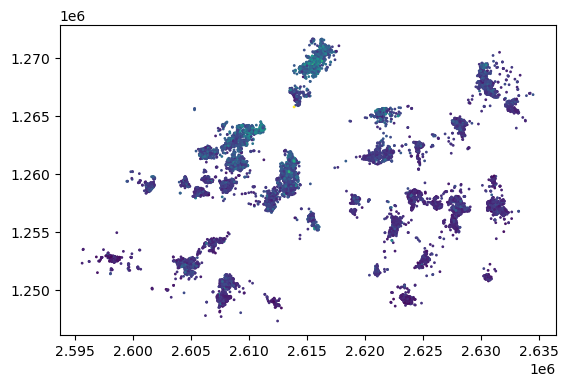

In [23]:
Xscaled.query('Agglo_Name == "Basel"').sample(10000).plot("RF", markersize = 1)

In [20]:
import seaborn as sns

<Axes: xlabel='net_income_ptp', ylabel='RF'>

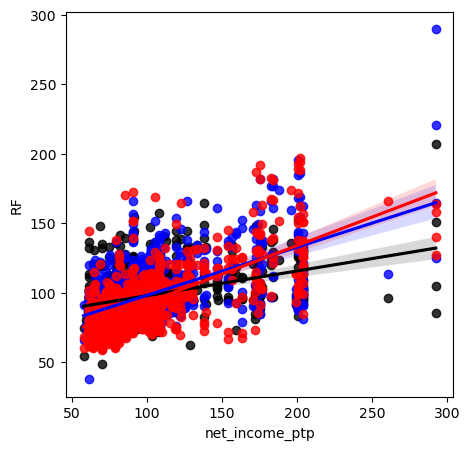

In [22]:
f, ax = plt.subplots(figsize = (5,5))

Xsamp = Xscaled.sample(1000)
sns.regplot(data = Xsamp, x = 'net_income_ptp', y = 'LinReg', ax = ax, color = 'black')
sns.regplot(data = Xsamp, x = 'net_income_ptp', y = 'XGB', ax = ax, color = 'blue')
sns.regplot(data = Xsamp, x = 'net_income_ptp', y = 'RF', ax = ax, color = 'red')


In [144]:
import seaborn as sns

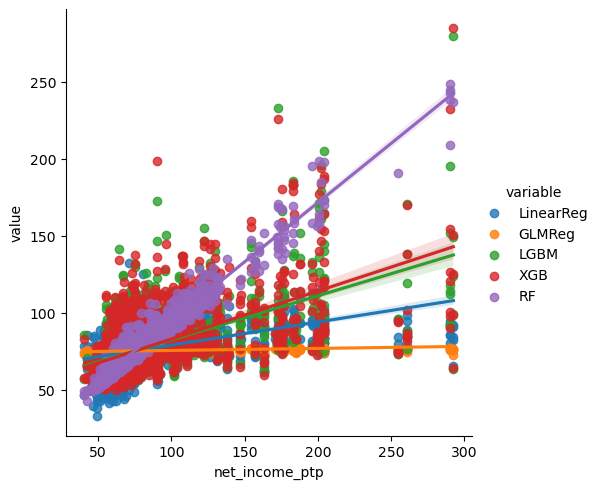

In [178]:
# f, ax = plt.subplots(figsize = (10,10))

sns.lmplot(data = res.sample(10000).melt(id_vars=['net_income_ptp','geoname']).query('geoname == "All"'), 
            x = 'net_income_ptp', y = 'value', hue = 'variable', scatter = True, ci = 95)


In [24]:
X_sampled = Xscaled[model_feats].sample(10000)
import shap
xgb_explainer = shap.TreeExplainer(xgb_model)
shap_values = xgb_explainer.shap_values(X_sampled)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
rf_explainer = shap.TreeExplainer(rf_model)
shap_values = rf_explainer.shap_values(X_sampled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


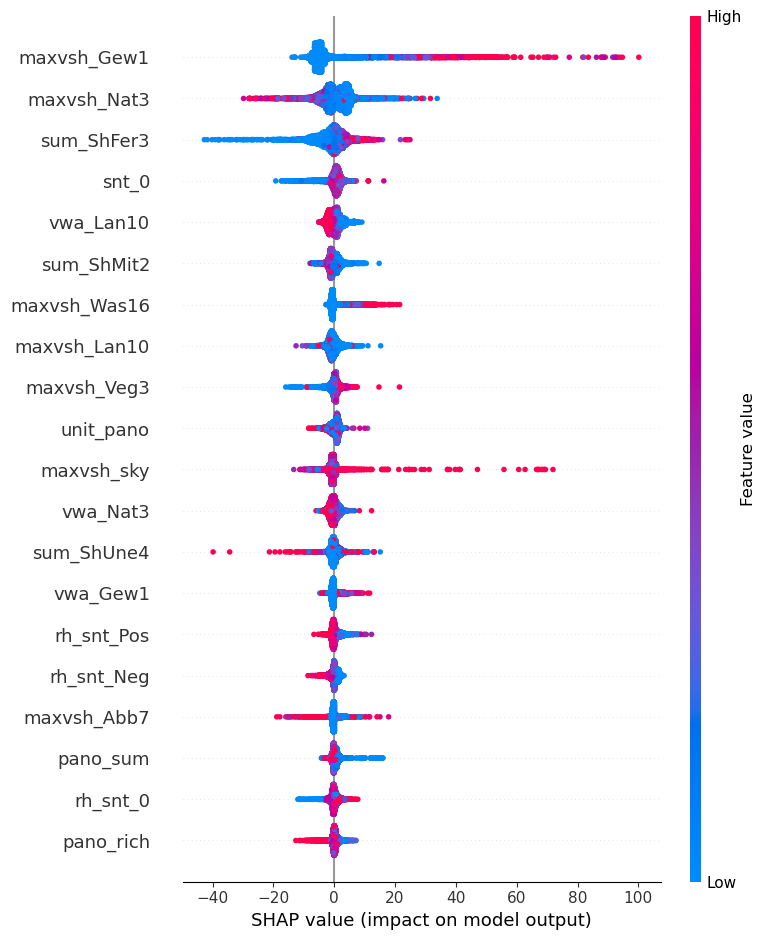

In [25]:
shap.summary_plot(shap_values, X_sampled)


<Axes: xlabel='XGB', ylabel='RF'>

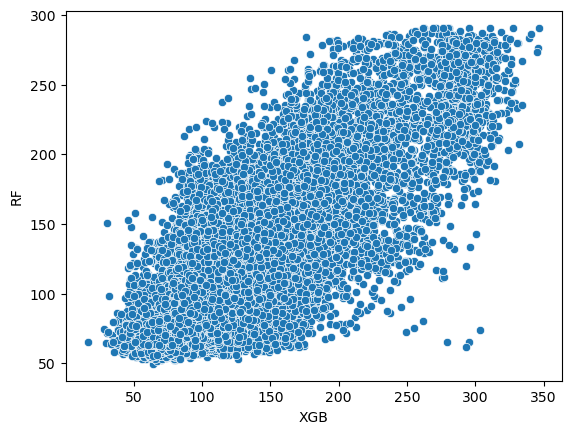

In [27]:
sns.scatterplot(data = Xscaled, x = 'XGB', y = 'RF')

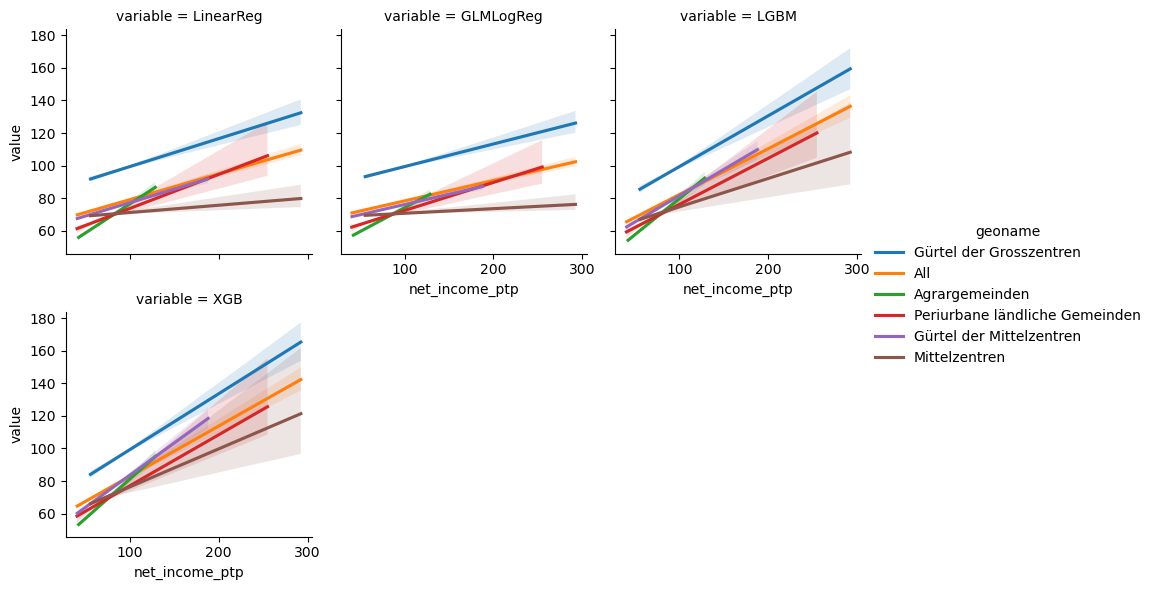

In [147]:
g = sns.FacetGrid(data = res.sample(10000).melt(id_vars=['net_income_ptp','geoname']), col = 'variable', hue='geoname', col_wrap=3)

g.map(sns.regplot, 'net_income_ptp','value', scatter= False).add_legend()

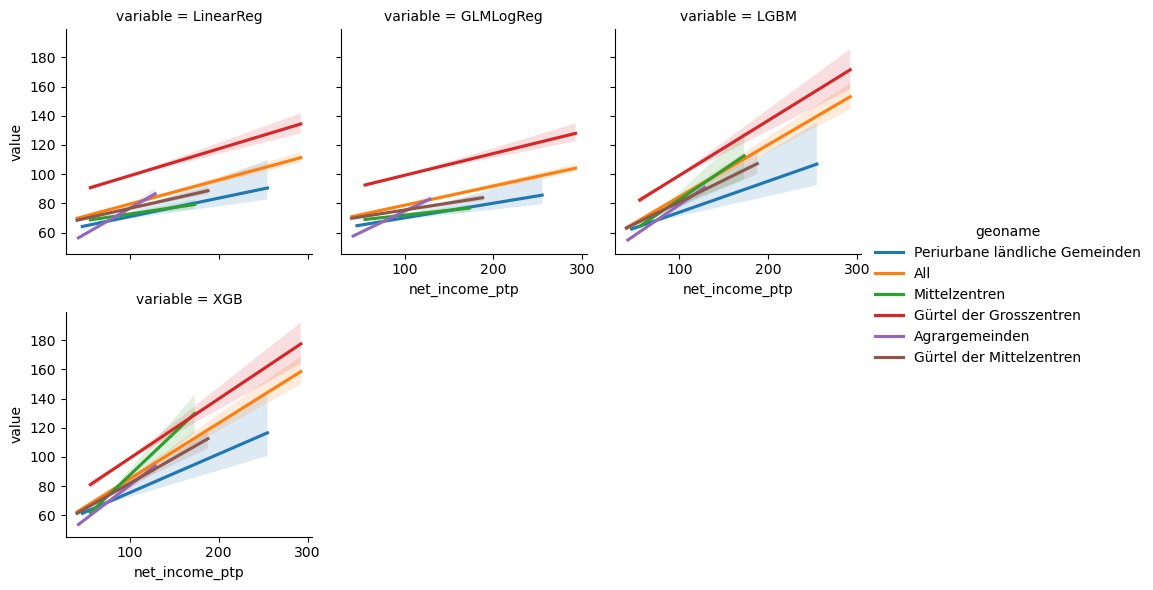

In [146]:
g = sns.FacetGrid(data = res.sample(10000).melt(id_vars=['net_income_ptp','geoname']), col = 'variable', hue='geoname', col_wrap=3)

g.map(sns.regplot, 'net_income_ptp','value', scatter= False).add_legend()

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd


def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners:param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier())
        ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['malignant', 'benign']
    for name, model in models:
        # kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        # cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        # this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
    return final